# Filter banks and MFCCs

Date: Sep 19, 2018

reference: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [1]:
from scipy.fftpack import dct
%run ../../lib/dsp.py
FILE = './aiueo.wav'

## Original sound

256161

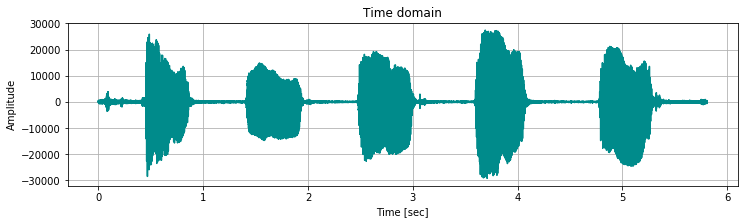

In [2]:
fs, wave = read(FILE)
setenv(figsize=[12,3], fs=fs, real_only=True, grid=True)
plot_wave(wave)
len(wave)

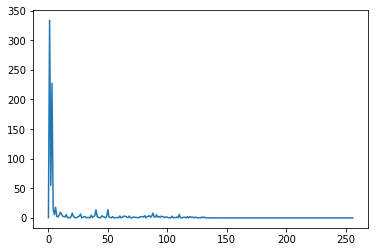

In [3]:
f, t, Sxx = sg.spectrogram(np.real(wave), nperseg=512, fs=fs)
plt.plot(Sxx.T[0])

Frequencies at peaks: [172.265625] Hz


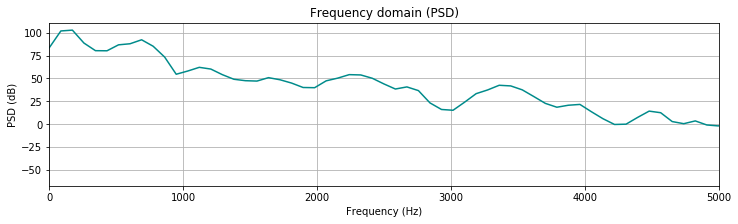

In [4]:
plot_welch(wave, nperseg=512, logscale=True, xlim=[0,5000])

## Pre-emphasis

$$ y(t) = x(t) - \alpha x(t-1) $$

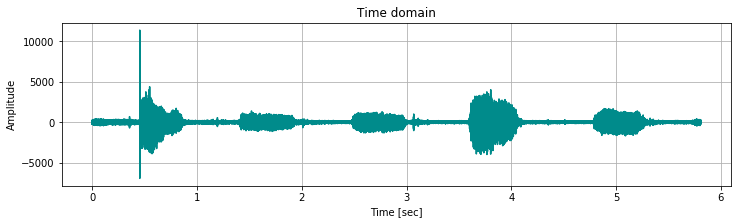

In [5]:
alpha = 0.97
wave = np.append(wave[0], wave[1:] - alpha * wave[:-1])
plot_wave(wave, real_only=True)

## Frames

In [6]:
#frame_size = 0.025  # 25msec
frame_size = 0.0115
frame_stride = frame_size/2.5
frame_length = int(frame_size * fs)
frame_step = int(frame_stride * fs)
frame_length, frame_step

(507, 202)

In [7]:
wave_length = len(wave)
num_frames = int(np.ceil(float(np.abs(wave_length - frame_length)) / frame_step))
wave_length, num_frames

(256161, 1266)

In [8]:
pad_wave_length = num_frames * frame_step + frame_length
pad_wave_length

256239

In [9]:
z = np.zeros((pad_wave_length - wave_length))
pad_wave = np.append(wave, z)
pad_wave

array([-204.  , -120.12,   88.46, ...,    0.  ,    0.  ,    0.  ])

In [10]:
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_wave[indices.astype(np.int32, copy=False)]
frames.shape

(1266, 507)

## Real FFT and spectrogram

In [11]:
frames *= np.hamming(frame_length)

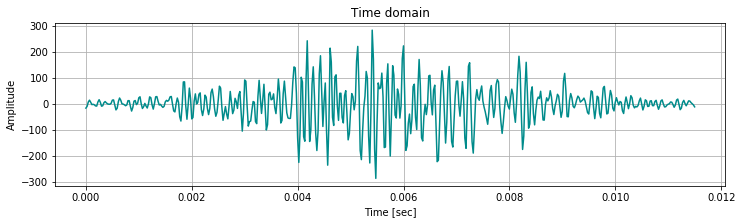

In [12]:
plot_wave(frames[0])

In [13]:
NFFT = 512
mag_frames = np.abs(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
num_samples = pow_frames.shape[1]  # The number of samples per frame
num_samples, pow_frames.shape

(257, (1266, 257))

In [14]:
t = np.linspace(0, len(wave)/fs, num_frames)  # Time
f = np.linspace(0, fs/2, num_samples)  # Frequency
len(t), len(f)

(1266, 257)

Text(0.5,1,'Spectrogram')

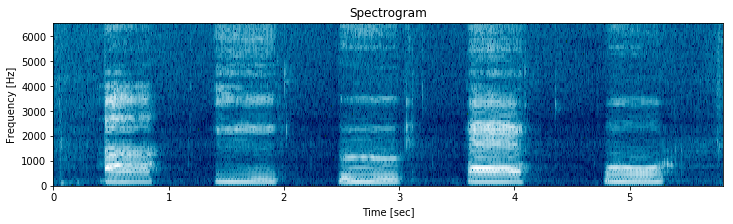

In [15]:
plt.figure(figsize=[12,3])
band = int(num_samples * 0.3)
plt.pcolormesh(t, f[:band], 20 * np.log10(pow_frames.T)[:band], cmap='ocean')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram")

## Filter bank on Mel scale

In [16]:
num_filters = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / fs)

filter_bank = np.zeros((num_filters, int(np.floor(NFFT / 2 + 1))))
for m in range(1, num_filters + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        filter_bank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        filter_bank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_bank.shape

(40, 257)

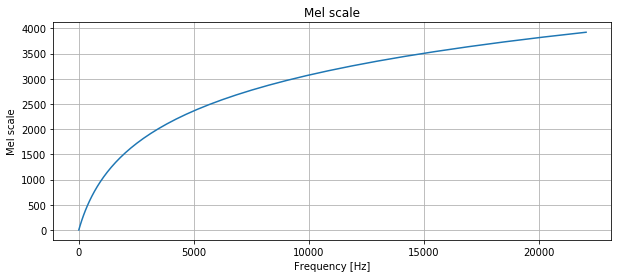

In [17]:
plt.figure(figsize=[10,4])
plt.plot(hz_points, mel_points)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mel scale')
plt.title('Mel scale')
plt.grid(True)

Text(0.5,1,'Filter banks on Mel scale')

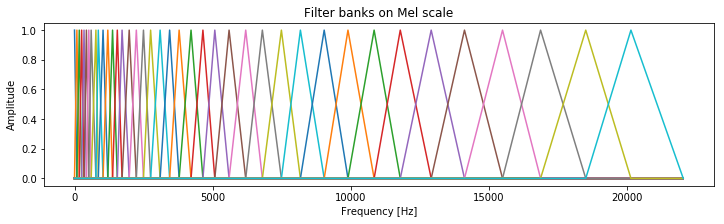

In [18]:
plt.figure(figsize=[12,3])
for i in range(num_filters):
    plt.plot(f, filter_bank[i])
plt.xlabel('Frequency [Hz]')    
plt.ylabel('Amplitude')
plt.title('Filter banks on Mel scale')

## Spectrogram on Mel scale

In [19]:
filtered_frames = np.dot(pow_frames, filter_bank.T)
filtered_frames = np.where(filtered_frames == 0, np.finfo(float).eps, filtered_frames)  # Numerical Stability
filtered_frames = 20 * np.log10(filtered_frames)  # dB

Text(0.5,1,'Spectrogram (Mel scale)')

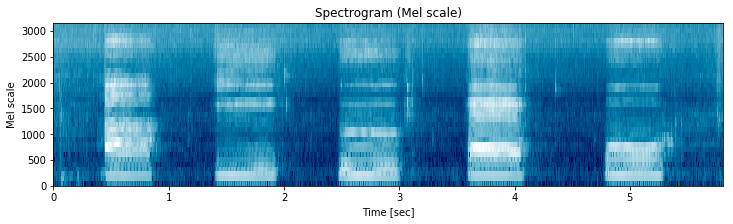

In [31]:
plt.figure(figsize=[12,3])
plt.pcolormesh(t, mel_points[:34], filtered_frames.T[:34], cmap='ocean')
plt.ylabel('Mel scale')
plt.xlabel('Time [sec]')
plt.title("Spectrogram (Mel scale)")

## DCT and MFCCs (Mel-frequency cepstral coefficients)

In [21]:
num_ceps = 12

In [22]:
# Coefficients 2-13 are retained
mfcc = dct(filtered_frames, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]  # DCT type 2

In [23]:
len(mfcc)

1266

Text(0.5,1,'MFCCs')

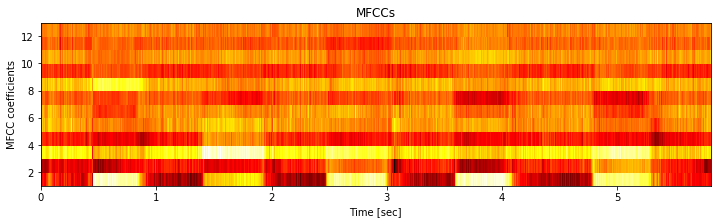

In [24]:
#t = np.linspace(0, len(wave)/fs, num_frames)
c = np.linspace(1, num_ceps+1, num_ceps+1).astype(int)
plt.figure(figsize=[12,3])
plt.pcolormesh(t, c, mfcc.T, cmap='hot')
plt.xlabel('Time [sec]')
plt.ylabel('MFCC coefficients')
plt.title("MFCCs")